In [1]:
# Purpose: Plotting the total ocean heat content drift in the new RDF spin-up
#          -> RDF = Repeat decade forcing for 1962-1971
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 18. 05. 2020      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         

save = '/g/data/e14/mv7494/HeatDist_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import cmocean as cm
from datetime import datetime # package for printing time in plot                                       
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
import cartopy.crs as ccrs # for maps     
import itertools
import cosima_cookbook as cc
from matplotlib import gridspec
from scipy import stats # create linear trend over the 3rd to 5th cycles for the upper 2000 m

import warnings
warnings.filterwarnings('ignore') # suppress warnings

import nc_time_axis
import cftime

# for displaying multiple output in one cell
from IPython.display import display as dp

# colours                                                                                               
ned_blue = [.12,.27,.54] # blue colour from the Dutch flag                                              
ned_red  = [.68,.10,.15] # red  "    "    "    "    "    "

from dask.distributed import Client
client = Client(n_workers=16)
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

### First get the land-sea mask

CPU times: user 2.18 s, sys: 868 ms, total: 3.05 s
Wall time: 10.2 s


Text(0.5, 1.0, 'JRA55-do Land-Sea Mask')

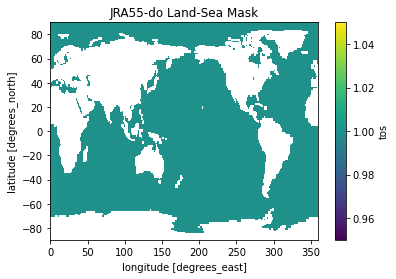

In [2]:
%%time
base_Had = '/g/data/e14/mv7494/'
tos = xr.open_mfdataset(base_Had + 'tos_for_land_sea_mask_remapbil.nc').groupby('time.year').mean('time').tos[0,:,:].fillna(0).load() # open temperature over ocean dataset and fill nan values with zeroes
landsea_mask = tos.where(tos>=0,1).where(tos<=0,1).squeeze() # replace all non-zero values with ones
landsea_mask = landsea_mask.where(landsea_mask != 0) # replace all zeroes with nan again, otherwise the GMSAT mean is different!
landsea_mask.plot(); plt.title('JRA55-do Land-Sea Mask')

### Time series with GMSOAT (Global Mean Surface Ocean Air Temperature)
- This is to show the linear increase between the RDF-Offset to RDF time periods

In [3]:
%%time
from cdo import *
cdo = Cdo()

base = '/g/data/e14/mv7494/HeatDist_input/EXP_PI_Offset_JRA55-do-1-3/'
base2 = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-3/atmos/3hrPt/tas/gn/v20180412/'

a = np.zeros(shape=(186,2)) # empty array which I then fill up
a[:,0] = np.linspace(1832,2017,186) # first column = year data

# first prepare the annual mean for the RDF-PI-Offset data
cdo.yearmean(input = ' -mergetime ' + base + 'tas/tas*.nc', output= base + 'tas_annual_mean_forcing_output190.nc', force = False)
# Wall time: 57.8 s



# now the annual mean for the linear transitional period
for i in range(186,205,1):
    # cycle through the different periods       -> output186 to output190 = RDF - PI_Offset
    #                                           -> output191 to output199 = Transitional period where I go back up to RDF 1960s forcing
    #                                           -> output200              = RDF period 1962-1971
    #                                           -> output201 to output204 = IAF period 1972-2017
    startTime = datetime.now()   # start clock 
    print('calculating annual mean output' + str(i))
    
    if i in range(191,199,1):
        cdo.yearmean(input = ' -mergetime ' + base + 'forcing_output'+str(i)+'/tas/tas*.nc', output= base + 'tas_annual_mean_forcing_output'+str(i)+'.nc', force = False)
        # Wall time: 59 s for one iteration  
    if i > 198: # for the IAF period of the plot from 1962-2017 I need to get the files in 10-year blocks from the /g/data/qv56 folder

        f1 = 'tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_'

        add_decade = [10, 20, 30, 40, 50, 60]
        b = list(range(1952+add_decade[i-205],1962+add_decade[i-205],1)) # add list of decades, i.e., [1962, 1963, 1964, ...1971], [1972, 1973, 1974, ...1981], 
                                                                         # which is advancing each iteration in ten-year blocks
        s = list(range(0,10)) # empty list

        if i == 204:
            b = b[0:6] # if the very last iteration, then only select [2012, 2013, 2014, 2015, 2016, 2017] because data for 2018 to 2021 does not exist
            s = list(range(0,6)) # empty list


        c = [] # empty list which I fill up
        for l in s: # loop through the number of files I would like
            c.append(l)
            c[l] = base2 + f1 + str(b[l]) + '01010000-' + str(b[l]) + '12312230.nc' # fill in empty list
        c = ' '.join(c) # write list into a single string with a separation/space between each element
        cdo.yearmean(input = ' -mergetime ' + c, output= base + 'tas_annual_mean_forcing_output'+str(i)+'.nc', force = False)

    print(datetime.now() - startTime) # end time of script


    if i in [186, 187, 188, 189, 190]:
        tas = (xr.open_dataset(base + 'tas_annual_mean_forcing_output190.nc').tas*landsea_mask).mean(['lat','lon']).values - 273.15
        # multiply SAT x ocean mask to only select SAT over the ocean
    else:
        tas = (xr.open_dataset(base + 'tas_annual_mean_forcing_output' + str(i) + '.nc').tas*landsea_mask).mean(['lat','lon']).values - 273.15

    # fill in the array with the data
    if i < 204:
        for year in range(10):
            a[(i-191)*10+year+50,1] = tas[year] # fill in the empty array
    else:
        for year in range(6):
            a[(i-191)*10+year+50,1] = tas[year] # fill in the empty array        

# remove the 1962-1971 baseline
a[:,1] = a[:,1] - np.mean(a[130:140,1])

calculating annual mean output186
0:00:00.000343
calculating annual mean output187
0:00:00.000095
calculating annual mean output188
0:00:00.000094
calculating annual mean output189
0:00:00.000080
calculating annual mean output190
0:00:00.000082
calculating annual mean output191
0:00:00.193336
calculating annual mean output192
0:00:00.192416
calculating annual mean output193
0:00:00.172604
calculating annual mean output194
0:00:00.207623
calculating annual mean output195
0:00:00.199608
calculating annual mean output196
0:00:00.187964
calculating annual mean output197
0:00:00.215640
calculating annual mean output198
0:00:00.195161
calculating annual mean output199
0:00:00.196907
calculating annual mean output200
0:00:00.193509
calculating annual mean output201
0:00:00.198213
calculating annual mean output202
0:00:00.184276
calculating annual mean output203
0:00:00.217798
calculating annual mean output204
0:00:00.192057
CPU times: user 1.54 s, sys: 1.22 s, total: 2.76 s
Wall time: 5.25 s


### Quick linear trends for plotting routine

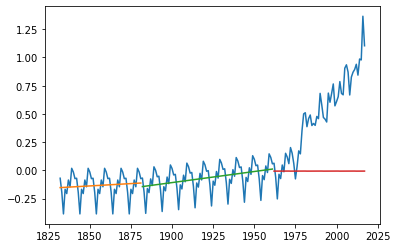

In [4]:
z = np.polyfit(a[0:50,0], a[0:50,1], 1)                             ; poly1 = np.poly1d(z) # trend over the RDF - PI-Offset period -> should be zero
z = np.polyfit(a[50:130,0], a[50:130,1], 1)                         ; poly2 = np.poly1d(z) # trend over the transitional period, should be linear increase
z = np.polyfit(a[130:186,0], np.array(list(a[130:140,1])*6)[:-4], 1); poly3 = np.poly1d(z) # trend over the RDF control period -> should be zero
plt.plot(a[:,0], a[:,1])
plt.plot(a[0:50,0],    poly1(a[0:50,0]))
plt.plot(a[50:130,0],  poly2(a[50:130,0]))
plt.plot(a[130:186,0], poly3(np.array(list(a[130:140,0])*6)[:-4]))

### Loading in HadCRUT5 data
- from the following script:
pre-industrial_sst_offset_RDF_to_NOAA_ERSSTv5_and_HadCRUT5.ipynb

CPU times: user 6.39 s, sys: 2.98 s, total: 9.37 s
Wall time: 14 s


<xarray.DataArray ()>
array(-0.13278467)

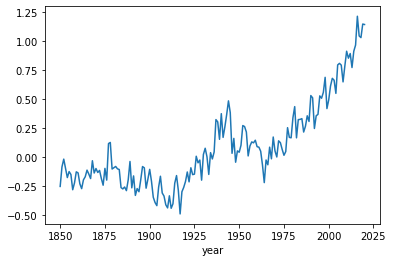

In [5]:
%%time
HadCRUT5 = xr.open_dataset(base_Had + 'HadCRUT5/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean_remapbil.nc').tas_mean.groupby('time.year').mean('time')
HadCRUT5 = HadCRUT5*landsea_mask # multiply with land-sea mask to only get values over the ocean
HadCRUT5 = HadCRUT5 - HadCRUT5.isel(year=slice(112,122)).mean('year') # remove the RDF 1962-1971 baseline
HadCRUT5_ts = HadCRUT5.mean(['lat','lon'])
HadCRUT5_ts.plot()
np.mean(HadCRUT5_ts[0:30]) # mean of years 1850 to 1979


### Plotting routine

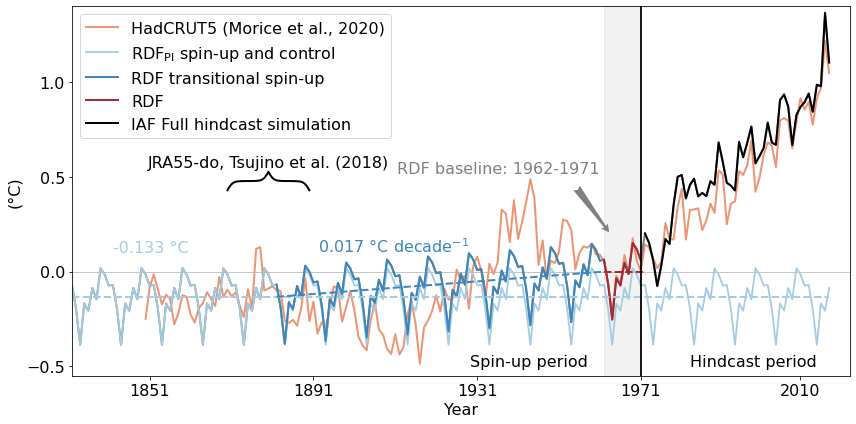

In [6]:
fig = plt.figure(figsize=(12,6),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(1,1) 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax1 = plt.subplot(gs[0,0])

# vertical lines and shadings
ax1.axhline(y= 0, c = 'grey', linewidth = .5, alpha = .9) # horizontal line at zero
ax1.axvspan(1962, 1971, color='grey', alpha=0.1)

ax1.hlines(y = HadCRUT5_ts[0:30].mean('year'), xmin = HadCRUT5_ts.year[0], xmax = HadCRUT5_ts.year[30], linestyle='--',
           color = rotblau[8]) # mean over 1850 to 1879
plt.plot(a[18:,0], HadCRUT5_ts[0:168], label='HadCRUT5 (Morice et al., 2020)', color=rotblau[6], linewidth=2) # plot HadCRUT5 from 1850 to 2017 only
plt.plot(a[:,0],a[:,1], color='grey', linewidth='2') # plot full time series in grey in the background    
plt.plot(a[0:186,0],np.array(list(a[0:10,1])*19)[:-4], color=rotblau[13], linewidth='1.8', label='RDF$_{\mathrm{PI}}$ spin-up and control')     # first 50 years of the figure with the RDF - PI-Offset data

plt.plot(a[50:130,0],a[50:130,1], color=rotblau[16], linewidth='2', label='RDF transitional spin-up')     # 80-year period where the data increases linearly back to the RDF period

#plt.plot(a[130:140,0],a[130:140,1], color=rotblau[3], linewidth='2', label='RDF Control')       # RDF period from 1962-1971
plt.plot(a[130:140,0],a[130:140,1], color=rotblau[3], linewidth='2', label='RDF')       # RDF period from 1962-1971

plt.plot(a[140:186,0],a[140:186,1], color='k', linewidth='2', label='IAF Full hindcast simulation')               # IAF period from 1972 onward


# adding the linear trends
ax1.hlines(y = np.mean(a[0:50,1]), xmin = a[0,0], xmax = a[185,0], linestyle='--', color = rotblau[13], linewidth=2) # mean over 1850 to 1879
plt.plot([1882, 1962],[-.133, 0], color=rotblau[16], linewidth='2', linestyle='--')  # custom-made trend line as the real one is slightly different due to rounding errors in
ax1.hlines(y = np.mean(a[130:140,1]), xmin = a[130,0], xmax = a[140,0],              # CDO and python -> need to discuss this with Matt
           linestyle='--', color = rotblau[3], linewidth=2)                # mean over 1962-2017 RDF


# adding the annotations
plt.text(1961, .52, 'RDF baseline: 1962-1971', c='grey', fontsize=16, horizontalalignment = 'right')
plt.text(1842, 0.1, str(np.round(np.mean(a[0:50,1]),3))+' °C', color=rotblau[13], fontsize=16)     
plt.text(1892, 0.1, str(np.round(0.133/8,3))+' °C decade$^{-1}$', color=rotblau[16], fontsize=16)     # from 0.133°C to 0°C over 8 decades
# plt.text(1998, 0.2, str(np.abs(np.round(np.mean(a[130:140,1]),3)))+' °C', color=rotblau[3], fontsize=16)     

plt.xlim([1832,2022]); plt.ylim([-.55,1.4])

plt.legend(fontsize=16)

plt.locator_params(axis='x', nbins=7); plt.locator_params(axis='y', nbins=5) # seven ticks on x-axis and five on y-axis
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
# title not required as I have the bold statement in the caption
# plt.title('Global Mean Surface Ocean Air Temperature Anomalies', fontsize = 16, loc='center')
plt.locator_params(axis='y', nbins=6)   # six ticks on y-axis
# Wall time: 12.8 s

ax1.axvline(x= 1971, c = 'k', linewidth = 2, alpha = .9) # vertical line

# arrow
# ax1.annotate('', xy=(1832, .3), xytext=(1842, .3),xycoords='data',
#                     size=20,arrowprops=dict(facecolor=rotblau[2], ec = 'none',arrowstyle="fancy")) # arrow SO -> PO
plt.text(1983, -.5, 'Hindcast period', color='k', fontsize=16, ha = 'left')     
plt.text(1958, -.5, 'Spin-up period', color='k', fontsize=16, ha = 'right')     

ax1.set_xlabel('Year', fontsize=16); ax1.set_ylabel('(°C)', fontsize=16)

ax1.set_xticks([1851, 1891, 1931, 1971, 2010]) # custom x ticks

# labels = [item.get_text() for item in ax1.get_xticklabels()]
# labels = ['1880', '1920', '1960', '2000/1971', '2010']
# ax1.set_xticklabels(labels)

# adding arrow   # end_coords, start_coords
ax1.annotate('', xy=(1963.5, .2), xytext=(1955, .45),xycoords='data',
                    size=20,arrowprops=dict(facecolor='grey', ec = 'none',arrowstyle="fancy")) # arrow IO -> SO

# adding a curly bracket to the legend
def draw_brace(ax, xspan, yy, text):
    """Draws an annotated brace on the axes."""
    xmin, xmax = xspan
    xspan = xmax - xmin
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin

    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin
    resolution = int(xspan/xax_span*400)*2+1 # guaranteed uneven
    beta = 300./xax_span # the higher this is, the smaller the radius

    x = np.linspace(xmin, xmax, resolution)
    x_half = x[:int(resolution/2)+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    y = yy + (.05*y - .01)*yspan # adjust vertical position

    ax.autoscale(False)
    ax.plot(x, y, color='black', linewidth=2)

    ax.text((xmax+xmin)/2., yy+.07*yspan, text, ha='center', va='bottom',fontsize=16)
draw_brace(ax1, (1870, 1890), .4, 'JRA55-do, Tsujino et al. (2018)')

# --- saving as 300 dpi .PNG image in specified folder ------------------------
plt.savefig(save + 'timeseries_GMSAT_during_the_last_bit_of_the_spin_up', dpi=300, facecolor='w', 
            edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches=None, 
            pad_inches=0.1, metadata=None)
# %% end of script ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Wall time: 23.4 s

### Load in files with xarray for model drift figure during spin-up

CPU times: user 11.5 s, sys: 1.2 s, total: 12.7 s
Wall time: 18.1 s


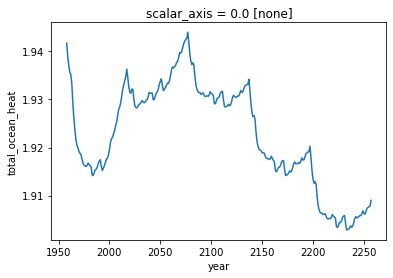

In [7]:
%%time
base = '/g/data/e14/mv7494/access-om2/archive/'

# load 1deg IAF SPIN-UP FROM ANDREW
# -------------------------------------------------------------------------------------
c = '/g/data/hh5/tmp/cosima/access-om2/1deg_jra55v13_iaf_spinup1_B1/output*/ocean/ocean_scalar.nc'                         
ds1 = xr.open_mfdataset(c,combine = 'by_coords',
                       chunks = {'time': 1},decode_times = True)
ds1 = ds1.total_ocean_heat.groupby('time.year').mean('time').chunk(50).load() 
# Wall time: 13.1 s
ds1.plot()

CPU times: user 44.6 s, sys: 9.79 s, total: 54.4 s
Wall time: 1min


Text(350, 1.9, '-3.55$\\times$10$^{21}$ J year$^{-1}$')

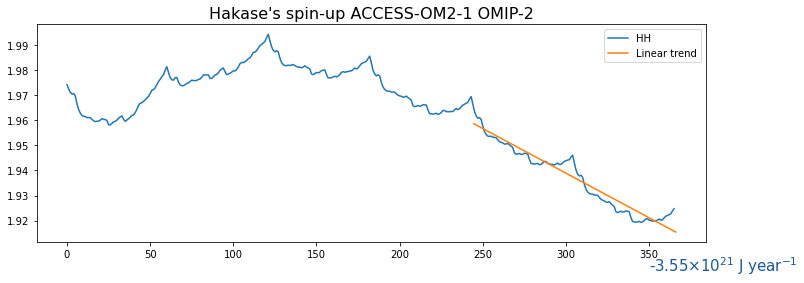

In [8]:
%%time
### Load in 1deg IAF SPIN-UP FROM HAKASE HAYASHIDA
# # -------------------------------------------------------------------------------------
base_omip = '/g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cycle' # read in the new omip simulations

# open all the files which are part of each cycle
OHC_1deg_HH_c1 = xr.open_mfdataset(base_omip + '1/output*/ocean/ocean_scalar.nc',decode_times = True).groupby('time.year').mean('time').total_ocean_heat.drop('scalar_axis').squeeze().values
OHC_1deg_HH_c2 = xr.open_mfdataset(base_omip + '2/output*/ocean/ocean_scalar.nc',decode_times = True).groupby('time.year').mean('time').total_ocean_heat.drop('scalar_axis').squeeze().values
OHC_1deg_HH_c3 = xr.open_mfdataset(base_omip + '3/output*/ocean/ocean_scalar.nc',decode_times = True).groupby('time.year').mean('time').total_ocean_heat.drop('scalar_axis').squeeze().values
OHC_1deg_HH_c4 = xr.open_mfdataset(base_omip + '4/output*/ocean/ocean_scalar.nc',decode_times = True).groupby('time.year').mean('time').total_ocean_heat.drop('scalar_axis').squeeze().values
OHC_1deg_HH_c5 = xr.open_mfdataset(base_omip + '5/output*/ocean/ocean_scalar.nc',decode_times = True).groupby('time.year').mean('time').total_ocean_heat.drop('scalar_axis').squeeze().values
OHC_1deg_HH_c6 = xr.open_mfdataset(base_omip + '6/output*/ocean/ocean_scalar.nc',decode_times = True).groupby('time.year').mean('time').total_ocean_heat.drop('scalar_axis').squeeze().values
# Wall time: 32.8 s

OHC_1deg_HH = np.zeros(366); t = np.linspace(0,366,366)

OHC_1deg_HH[0:61]    = OHC_1deg_HH_c1
OHC_1deg_HH[61:122]  = OHC_1deg_HH_c2
OHC_1deg_HH[122:183] = OHC_1deg_HH_c3
OHC_1deg_HH[183:244] = OHC_1deg_HH_c4
OHC_1deg_HH[244:305] = OHC_1deg_HH_c5
OHC_1deg_HH[305:366] = OHC_1deg_HH_c6


# fit a 1st degree polynomial to the last two cycles
z1 = np.polyfit(t[244:366], OHC_1deg_HH[244:366], 1)
stat1 = stats.linregress(t,OHC_1deg_HH)# get the statistical values
polyHH = np.poly1d(z1) # construct the polynomial 

fig= plt.figure(figsize=(12,4))
plt.plot(OHC_1deg_HH, label='HH '); plt.plot(t[244:366],polyHH(t[244:366]), label='Linear trend'); plt.legend()
plt.title('Hakase\'s spin-up ACCESS-OM2-1 OMIP-2', fontsize=16)
# trend value 
plt.text(350, 1.9, str(np.round(polyHH[1]*1e25/1e21,2)) + r'$\times$10$^{21}$ J year$^{-1}$', fontsize=15, 
         horizontalalignment = 'left', color = rotblau[18])
# Wall time: 4min 31s

In [11]:
%%time
# load 1deg SPIN-UP with PI_Offset
# -------------------------------------------------------------------------------------
ds5 = xr.open_mfdataset(base+'1deg_jra55_rdf_spinup_PI_Offset/output*/ocean/ocean_scalar.nc',
                        chunks = {'time': 1},combine = 'by_coords',decode_times = True, use_cftime=True)
ds5 = ds5.total_ocean_heat.groupby('time.year').mean('time').load()

# load 1deg SPIN-UP with PI_Offset continued
# -------------------------------------------------------------------------------------
ds6 = xr.open_mfdataset(base+'1deg_jra55_rdf_spinup_PI_Offset_continued/output*/ocean/ocean_scalar.nc',combine = 'by_coords',decode_times = True)
ds6 = ds6.total_ocean_heat.groupby('time.year').mean('time').load()

# load 1deg CONTROL
# -------------------------------------------------------------------------------------                                                      
ds7 = xr.open_mfdataset(base+'1deg_jra55_rdf_branch2000_Control_PI_Offset/output*/ocean/ocean_scalar.nc',combine = 'by_coords', chunks = {'time': 1},decode_times = True)
ds7 = ds7.total_ocean_heat.sel(time=slice('1972-01','2017-12')).groupby('time.year').mean('time').load()

# load 1deg SPIN-UP with PI_Offset with scaling
# -------------------------------------------------------------------------------------                                                    
ds8 = xr.open_mfdataset(base+'1deg_jra55_rdf_spinup_PI_Offset_scaling/output*/ocean/ocean_scalar.nc',combine = 'by_coords', chunks = {'time': 1},decode_times = True)
ds8 = ds8.total_ocean_heat.groupby('time.year').mean('time').load()

# load 1deg SPIN-UP with PI_Offset with scaling
# -------------------------------------------------------------------------------------                                                    
ds9 = xr.open_mfdataset(base+'1deg_jra55_iaf_branch2000_PI_Offset/output*/ocean/ocean_scalar.nc',combine = 'by_coords', chunks = {'time': 1},decode_times = True)
ds9 = ds9.total_ocean_heat.sel(time=slice('1972-01','2017-12')).groupby('time.year').mean('time').load()
# Wall time: 1min 42s

CPU times: user 1min 14s, sys: 7.8 s, total: 1min 21s
Wall time: 1min 25s


### Calculate the linear trend in the control run from 1972 onward

-4.926736424020183e+20

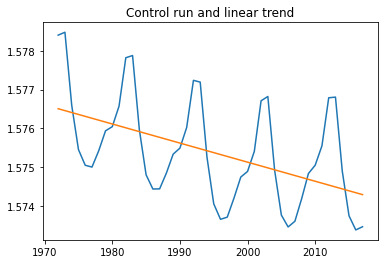

In [12]:
b = np.zeros(len(ds7.year))
ds77 = ds7 * 1e25 # convert back to 1e25 J
for s in range(len(ds7.year)): # remove double brackets from list
    b[s] = ds77[s]
z = np.polyfit(ds77.year, b, 1); poly1 = np.poly1d(z) # trend calculation

plt.plot(ds7.year, ds7, label='Spin-up cont.'); plt.title('Control run and linear trend')
plt.plot(ds7.year, poly1(ds7.year)/1e25, label='Trend')
poly1[1] # the linear trend

### Plotting routine

In [13]:
# %%time
# # initialise figure
# fig = plt.figure(figsize=(16, 6),tight_layout=True,facecolor='w',edgecolor='k')

# # first panel ------------------------------------------------------------------------------ #
# # ------------------------------------------------------------------------------------------ #
# ax1 = fig.add_subplot(1,2,1) # plot 1 spans all subplots on first row
# ax1.text(0, 1.02,string.ascii_lowercase[0]+')', transform=ax1.transAxes, size=16, weight='normal') # bold letter a at the top
# ax1.text(0.87, .16,string.ascii_lowercase[1]+')', transform=ax1.transAxes, size=16, weight='normal') # bold letter a at the top

# # 1° runs
# p4 = plt.plot(ds1.year-1958,ds1, c = rotblau[18], label = 'IAF spin-up (Kiss et al., 2020)', linewidth=2)

# # p1 = plt.plot(ds2.year-1962,ds2,c = rotblau[3], label = 'RDF Spin-up', linewidth=2)
# # p3 = plt.plot(ds3.year+2010-1971, ds3, c = rotblau[6], label = 'RDF Control', linewidth=2)
# # p3 = plt.plot(ds4.year+2010-1971, ds4, c = 'k', label = 'IAF Run at Year 2000', linewidth=2)

# p1 = plt.plot(ds5.year-1962, ds5, c = rotblau[3], linewidth=2, label = 'RDF$_{\mathrm{PI}}$ spin-up')
# p1 = plt.plot(ds6.year-1962,ds6,c = rotblau[15], linewidth=2, label = 'RDF$_{\mathrm{PI}}$ control')
# p1 = plt.plot(ds7.year-1972+2000,ds7,c = rotblau[15], linewidth=2)#label = 'RDF$_{\mathrm{PI-Offset}}$ IAF Run at Year 500', linewidth=2)

# p1 = plt.plot(ds8.year-1972+2000,ds8,c = 'k', linewidth=2, label = 'IAF Full')

# # p1 = plt.plot(ds9.year-1972+2000,ds9,c = 'k', linewidth=2, label = 'RDF$_{\mathrm{PI}}$ IAF Run at Year 2000')


# # trend in the continued RDF_PI_Offset spin-up (i.e., the control run)
# p1 = plt.plot(ds11.year-1958, poly2(ds11.year)/1e25, c = rotblau[15], linestyle = '--')

# # trend value 
# plt.text(350, 1.9, str(np.round(poly1[1]/1e21,2)) + r'$\times$10$^{21}$ J year$^{-1}$', fontsize=15, 
#          horizontalalignment = 'left', color = rotblau[18])

# # # 1/4° runs
# # p4 = plt.plot(ds4.year-1961, ds4, c = 'orange', label = '1/4° RDF spin-up') 
# # p5 = plt.plot(ds5.year+500-1971, ds5, c = 'r', label = '1/4° control') 
# # p6 = plt.plot(ds6.year+500-1971, ds6,c = 'g', label = '1/4° IAF run at year 500') 

# # # add text
# # plt.text(400, 2.05, 'at '+str(1971+len(ds6))+'-12', color='g', fontsize=16)
# # plt.text(400, 2.0,  'at '+str(1971+len(ds5))+'-12', color='r', fontsize=16)

# # set fontsizes and labels
# ax1.set_xlabel('Year', fontsize=16)
# ax1.set_ylabel('($10^{25}$ J)', fontsize=16)
# plt.title('ACCESS-OM2-1 global ocean heat content', fontsize=16) # title
# plt.xticks(fontsize=16) # ticklabel  size
# plt.yticks(fontsize=16)
# ax1.yaxis.offsetText.set_fontsize(16)
# ax1.yaxis.major.formatter._useMathText = True # use scientific notation

# ax1.legend(fontsize = 16) # add legend

# # ax1.set_xticklabels(['','1','500','1000','1500','2000']) # set 1 as first x-axis label

# xt = ax1.get_xticks() # adding a custom tick for the 1972-2018 period

# plt.locator_params(axis='y', nbins=8) # number of y ticks and ticklabels
# plt.locator_params(axis='x', nbins=5) # number of y ticks and ticklabels


# # create a rectangle patch
# import matplotlib.patches as patches
# # For visualization purposes we mark the bounding box by a rectangle
# ax1.add_patch(plt.Rectangle((1861, 1.57), 202, .04, linewidth=1, edgecolor='k', facecolor='none'))

# # second  panel ---------------------------------------------------------------------------- #
# # ------------------------------------------------------------------------------------------ #
# ax1 = fig.add_subplot(1,2,2) # plot 1 spans all subplots on first row
# ax1.text(0, 1.02,string.ascii_lowercase[1]+')', transform=ax1.transAxes, size=16, weight='normal') # bold letter a at the top


# # vertical shading and labelling of RDF baseline
# ax1.axvspan(1990, 2000, color='grey', alpha=0.1)
# plt.text(1980, 1.6, 'baseline: 1962-1971', c='grey', fontsize=16, horizontalalignment = 'right')


# # adding arrow   # end_coords, start_coords
# ax1.annotate('', xy=(1993.5, 1.594), xytext=(1980, 1.599),xycoords='data',
#                     size=20,arrowprops=dict(facecolor='grey', ec = 'none',arrowstyle="fancy")) # arrow IO -> SO
             
# # p1 = plt.plot(ds2.year-1962,ds2,c = rotblau[3], label = 'RDF Spin-up', linewidth=2) 
# # p3 = plt.plot(ds3.year+2010-1971, ds3, c = rotblau[6], label = 'RDF Control', linewidth=2) 
# # p3 = plt.plot(ds4.year+2010-1971, ds4, c = 'k', label = 'IAF Run at Year 2000', linewidth=2) 

# p1 = plt.plot(ds5.year-1962,ds5,c = rotblau[3], linewidth=2) # the spin-up and the transitional period
# p1 = plt.plot(ds6.year-1962,ds6,c = rotblau[15], linewidth=2) # the control run
# p1 = plt.plot(ds7.year-1972+2000,ds7,c = rotblau[15], linewidth=2)#label = 'RDF$_{\mathrm{PI-Offset}}$ IAF Run at Year 500', linewidth=2)
# # p1 = plt.plot(ds7.year+2000, poly1(ds7.year+2000-ds7.year[0])/1e25, c = rotblau[3], linestyle='--') 
# p1 = plt.plot(ds8.year+2000-ds8.year[0],ds8,c = 'k', linewidth=2) # the IAF run

# # trend in the continued RDF_PI_Offset spin-up (i.e., the control run)
# p1 = plt.plot(ds7.year-1972+2000, poly1(ds7.year)/1e25, c = rotblau[15], linestyle = '--')

# # trend value 
# plt.text(2002, 1.579, str(np.round(poly1[1]/1e21,2)) + r'$\times$10$^{21}$ J year$^{-1}$', fontsize=15, 
#          horizontalalignment = 'left', color = rotblau[15])

# plt.xlim([1861, 2063]); plt.ylim([1.57, 1.61])         

    

# # set fontsizes and labels
# ax1.set_xlabel('Year', fontsize=16); plt.xticks(fontsize=16); plt.yticks(fontsize=16)
# plt.title('Inset', fontsize=16) # title
# ax1.yaxis.offsetText.set_fontsize(16)
# ax1.yaxis.major.formatter._useMathText = True # use scientific notation

# # re-write the labels because the actual year 1971 AD is the year 2000 of the spin-up
# ax1.set_xticks([ 1881,    1921,   1961,   2000,   2041]) # custom x ticks
# labels = [item.get_text() for item in ax1.get_xticklabels()]
# labels =       ['1851', '1891', '1931', '1971', '2010']
# ax1.set_xticklabels(labels)
# plt.locator_params(axis='x', nbins=7); plt.locator_params(axis='y', nbins=5) # seven ticks on x-axis and five on y-axis

# # more annotations
# ax1.axvline(x= 2000, c = 'grey', linewidth = 2, alpha = .9) # black vertical line
# plt.text(2003, 1.571, 'Hindcast period', color='k', fontsize=16, ha = 'left')     
# plt.text(1987, 1.571, 'Spin-up period', color='k', fontsize=16, ha = 'right')  

# # --- saving as 300 dpi .PNG image in specified folder ------------------------
# plt.savefig(save + 'timeseries_OHC_spin-up', dpi=300, facecolor='w', 
#             edgecolor='w', orientation='landscape', papertype=None, 
#             format=None, transparent=False, bbox_inches=None, 
#             pad_inches=0.1, metadata=None)
# #print(datetime.now() - startTime) # end time of script
# # %% end of script ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# # Wall time: 28.6 s

### Next, combine panels into a big Methods Figure

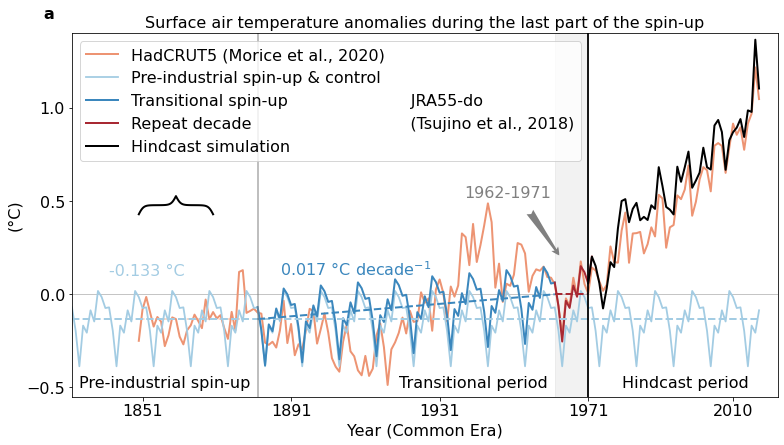

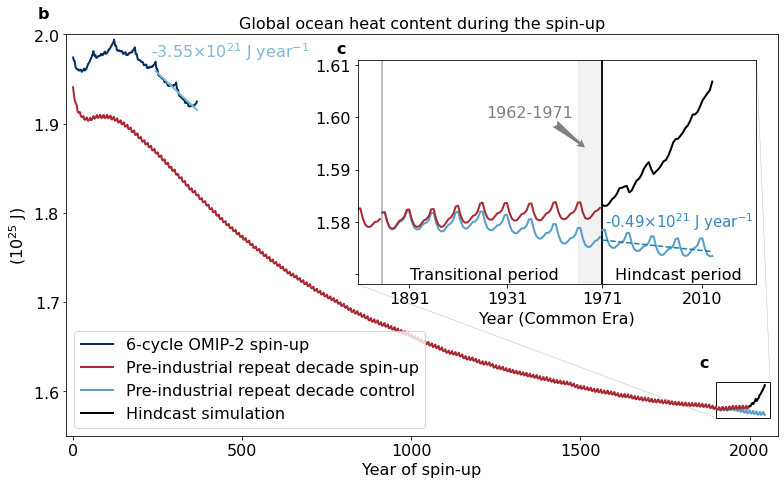

In [31]:
fig = plt.figure(figsize=(11,12),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2, 2, width_ratios=[1,1], height_ratios=[.9,1]) 

# --------------------------------------------------------------------------- #
# --- Panel 1: EXP Design -- ------------------------------------------------ #
# --------------------------------------------------------------------------- #
ax1 = plt.subplot(gs[0,:])
ax1.text(-.04, 1.04,'a', transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top


# vertical lines and shadings
ax1.axhline(y= 0, c = 'grey', linewidth = .5, alpha = .9) # horizontal line at zero
ax1.axvspan(a[130,0], a[139,0], color='grey', alpha=0.1)

ax1.hlines(y = HadCRUT5_ts[0:30].mean('year'), xmin = HadCRUT5_ts.year[0], xmax = HadCRUT5_ts.year[30], linestyle='--', color = rotblau[8]) # mean over 1850 to 1879
plt.plot(a[18:,0], HadCRUT5_ts[0:168], label='HadCRUT5 (Morice et al., 2020)', color=rotblau[6], linewidth=2) # plot HadCRUT5 from 1850 to 2017 only

plt.plot(a[0:186,0],np.array(list(a[0:10,1])*19)[:-4], color=rotblau[13], linewidth='1.8', label='Pre-industrial spin-up & control')     # first 50 years of the figure with the RDF - PI-Offset data

plt.plot(a[50:131,0],a[50:131,1], color=rotblau[16], linewidth='2', label='Transitional spin-up                        JRA55-do ')     # 80-year period where the data increases linearly back to the RDF period

#plt.plot(a[130:140,0],a[130:140,1], color=rotblau[3], linewidth='2', label='RDF Control')       # RDF period from 1962-1971
plt.plot(a[130:141,0],a[130:141,1], color=rotblau[3], linewidth='2', label='Repeat decade                               (Tsujino et al., 2018)')       # RDF period from 1962-1971

plt.plot(a[139:186,0],a[139:186,1], color='k', linewidth='2', label='Hindcast simulation')               # IAF period from 1972 onward

# adding the linear trends
ax1.hlines(y = np.mean(a[0:50,1]), xmin = a[0,0], xmax = a[185,0], linestyle='--', color = rotblau[13], linewidth=2) # mean over 1850 to 1879
plt.plot([1882, 1962],[-.133, 0], color=rotblau[16], linewidth='2', linestyle='--')  # custom-made trend line as the real one is slightly different due to rounding errors in
ax1.hlines(y = 0, xmin = a[130,0], xmax = a[139,0],              # CDO and python -> need to discuss this with Matt
           linestyle='--', color = rotblau[3], linewidth=2)                # mean over 1962-2017 RDF

# adding the annotations
plt.text(1961, .52, '1962-1971', c='grey', fontsize=16, horizontalalignment = 'right')
plt.text(1842, 0.1, str(np.round(np.mean(a[0:50,1]),3))+' °C', color=rotblau[13], fontsize=16)     
plt.text(1888, 0.1, str(np.round(0.133/8,3))+' °C decade$^{-1}$', color=rotblau[16], fontsize=16)     # from 0.133°C to 0°C over 8 decades
# plt.text(1998, 0.2, str(np.abs(np.round(np.mean(a[130:140,1]),3)))+' °C', color=rotblau[3], fontsize=16)     

plt.xlim([1832,2022]); plt.ylim([-.55,1.4])
ax1.axvline(x= a[139,0], c = 'k', linewidth = 2, alpha = .9) # vertical line
ax1.axvline(x= a[50,0], c = 'grey', linewidth = 2, alpha = .5) # grey vertical line


plt.legend(fontsize=16)

plt.locator_params(axis='x', nbins=7); plt.locator_params(axis='y', nbins=5) # seven ticks on x-axis and five on y-axis
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
# title not required as I have the bold statement in the caption
# plt.title('Global Mean Surface Ocean Air Temperature Anomalies', fontsize = 16, loc='center')
plt.locator_params(axis='y', nbins=6)   # six ticks on y-axis
# Wall time: 12.8 s

# arrow
# ax1.annotate('', xy=(1832, .3), xytext=(1842, .3),xycoords='data',
#                     size=20,arrowprops=dict(facecolor=rotblau[2], ec = 'none',arrowstyle="fancy")) # arrow SO -> PO
plt.text(1980, -.5, 'Hindcast period', color='k', fontsize=16, ha = 'left')     
plt.text(1880, -.5, 'Pre-industrial spin-up', color='k', fontsize=16, ha = 'right')   
plt.text(1960, -.5, 'Transitional period', color='k', fontsize=16, ha = 'right')   

ax1.set_xlabel('Year (Common Era)', fontsize=16); ax1.set_ylabel('(°C)', fontsize=16)

ax1.set_xticks([1851, 1891, 1931, 1971, 2010]) # custom x ticks

# labels = [item.get_text() for item in ax1.get_xticklabels()]
# labels = ['1880', '1920', '1960', '2000/1971', '2010']
# ax1.set_xticklabels(labels)

# adding arrow   # end_coords, start_coords
ax1.annotate('', xy=(1963.5, .2), xytext=(1955, .45),xycoords='data',
                    size=20,arrowprops=dict(facecolor='grey', ec = 'none',arrowstyle="fancy")) # arrow IO -> SO

# adding a curly bracket to the legend
def draw_brace(ax, xspan, yy, text):
    """Draws an annotated brace on the axes."""
    xmin, xmax = xspan
    xspan = xmax - xmin
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin

    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin
    resolution = int(xspan/xax_span*400)*2+1 # guaranteed uneven
    beta = 300./xax_span # the higher this is, the smaller the radius

    x = np.linspace(xmin, xmax, resolution)
    x_half = x[:int(resolution/2)+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    y = yy + (.05*y - .01)*yspan # adjust vertical position

    ax.autoscale(False)
    ax.plot(x, y, color='black', linewidth=2)

    ax.text((xmax+xmin)/2., yy+.07*yspan, text, ha='center', va='bottom',fontsize=16)
draw_brace(ax1, (1850, 1870), .4, '')# 'JRA55-do, Tsujino et al. (2018)') # create brace with text label

plt.title('Surface air temperature anomalies during the last part of the spin-up', fontsize=16)

# ax1.annotate(r"$\}$", xy=(1900.5, .4), xytext=(1910, .9), fontsize=66,zorder=10) # arrow IO -> SO

fig = plt.figure(figsize=(11,12),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2, 2, width_ratios=[1,1], height_ratios=[.9,1]) 

# --------------------------------------------------------------------------- #
# --- Panel 2: Spin-up ------------------------------------------------------ #
# --------------------------------------------------------------------------- #
ax1 = plt.subplot(gs[1,:])

# plot grey lines connecting the inset with the main plot
plt.plot([847, 1903], [1.719, 1.57], linewidth=.5, c = 'grey', alpha=.5) 
plt.plot([2021, 2061], [1.97, 1.609], linewidth=.5, c = 'grey', alpha=.5) 

ax1.text(-.04, 1.04,'b', transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
ax1.text(0.38, .954,'c', transform=ax1.transAxes, size=16, weight='bold') 
ax1.text(0.89, .17,'c', transform=ax1.transAxes, size=16, weight='bold') 

# 1° runs
p4 = plt.plot(t,OHC_1deg_HH, c = rotblau[20], label = '6-cycle OMIP-2 spin-up', linewidth=2)
# trend in the continued RDF_PI_Offset spin-up (i.e., the control run)
p1 = plt.plot(t[244:366], polyHH(t[244:366]), c = rotblau[14], linewidth=2)
# trend value 
plt.text(230, 1.975, str(np.round(polyHH[1]*1e25/1e21,2)) + r'$\times$10$^{21}$ J year$^{-1}$', fontsize=16, 
         horizontalalignment = 'left', color = rotblau[14])

# -------------- 
p1 = plt.plot(ds5.year-1962,ds5,c = rotblau[3], linewidth=2, label = 'Pre-industrial repeat decade spin-up')       # the spin-up
p1 = plt.plot(ds6.year-1962,ds6,c = rotblau[15], linewidth=2)      # the spin-up continued
p1 = plt.plot(ds7.year-1972+2000,ds7,c = rotblau[15], linewidth=2, label = 'Pre-industrial repeat decade control') # the control simulations
p1 = plt.plot(ds8.year-1962,ds8,c = rotblau[3], linewidth=2)       # the scaling spin-up
p1 = plt.plot(ds9.year-1972+2000,ds9,c = 'k', linewidth=2, label = 'Hindcast simulation')         # the interannual hindcast simulation
# -------------- 

# p1 = plt.plot(ds5.year-1962, ds5, c = rotblau[3], linewidth=2, label = 'Pre-industrial repeat decade spin-up')
# p1 = plt.plot(ds6.year-1962,ds6,c = rotblau[15], linewidth=2, label = 'Pre-industrial repeat decade control')
# p1 = plt.plot(ds7.year-1972+2000,ds7,c = rotblau[15], linewidth=2)#label = 'RDF$_{\mathrm{PI-Offset}}$ IAF Run at Year 500', linewidth=2)
# p1 = plt.plot(ds8.year-1972+2000,ds8,c = 'k', linewidth=2, label = 'Hindcast simulation')

# set fontsizes and labels
ax1.set_xlabel('Year of spin-up', fontsize=16)
ax1.set_ylabel('($10^{25}$ J)', fontsize=16)
plt.title('Global ocean heat content during the spin-up', fontsize=16) # title
plt.xticks(fontsize=16) # ticklabel  size
plt.yticks(fontsize=16)
ax1.yaxis.offsetText.set_fontsize(16)
ax1.yaxis.major.formatter._useMathText = True # use scientific notation

ax1.legend(fontsize = 16, loc='lower left') # add legend

xt = ax1.get_xticks() # adding a custom tick for the 1972-2018 period

plt.locator_params(axis='y', nbins=6) # number of y ticks and ticklabels
plt.locator_params(axis='x', nbins=5) # number of y ticks and ticklabels

# create a rectangle patch
import matplotlib.patches as patches
# For visualization purposes we mark the bounding box by a rectangle
ax1.add_patch(plt.Rectangle((1900, 1.57), 160, .04, linewidth=.9, edgecolor='k', facecolor='none'))
# ax3 = plt.axes([0,0,1,1])
# from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)
# ip = InsetPosition(ax1,[.88,.03,.08,.11]) # position of inset (x0, y0, width, height)
# plt.locator_params(axis='y', nbins=7); plt.locator_params(axis='x', nbins=9) # number of y ticks and ticklabels
# ax3.set_axes_locator(ip); ax3.set_xticklabels([]); ax3.set_yticklabels([])
# ax3.set_facecolor("none") # transparent inset

plt.xlim([-20, 2083]); plt.ylim([1.55, 2])    

# --------------------------------------------------------------------------- #
# --- Panel 3: Inset -------------------------------------------------------- #
# --------------------------------------------------------------------------- #
ax2 = plt.axes([0,0,1,1])
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)
ip2 = InsetPosition(ax1, [.41,.377,.56,.56]) # position of inset (x0, y0, width, height)
ax2.set_axes_locator(ip2)

# more annotations
ax2.axvline(x= 2000, c = 'k', linewidth = 2, alpha = .9) # black vertical line
ax2.axvline(x= 1910, c = 'grey', linewidth = 2, alpha = .5) # grey vertical line

# vertical shading and labelling of RDF baseline
ax2.axvspan(1990, 2000, color='grey', alpha=0.1)
plt.text(1988, 1.6, '1962-1971', c='grey', fontsize=16, horizontalalignment = 'right')


# adding arrow   # end_coords, start_coords
ax2.annotate('', xy=(1993.5, 1.594), xytext=(1980, 1.599),xycoords='data',
                    size=20,arrowprops=dict(facecolor='grey', ec = 'none',arrowstyle="fancy")) # arrow IO -> SO

p1 = plt.plot(ds5.year-1962,ds5,c = rotblau[3], linewidth=2) # the spin-up
p1 = plt.plot(ds6.year-1962,ds6,c = rotblau[15], linewidth=2) # the spin-up continued

p1 = plt.plot(ds7.year-1972+2000,ds7,c = rotblau[15], linewidth=2) # the control simulations
p1 = plt.plot(ds7.year-1972+2000, poly1(ds7.year)/1e25, linestyle='--')

plt.text(2001, 1.579, str(np.round(poly1[1]/1e21,2)) + r'$\times$10$^{21}$ J year$^{-1}$', fontsize=15, 
         horizontalalignment = 'left', color = rotblau[16]) # trend value 

p1 = plt.plot(ds8.year-1962,ds8,c = rotblau[3], linewidth=2) # the scaling spin-up
p1 = plt.plot(ds9.year-1972+2000,ds9,c = 'k', linewidth=2) # the scaling spin-up



# p1 = plt.plot(ds2.year-1962,ds2,c = rotblau[3], label = 'RDF Spin-up', linewidth=2) 
# p3 = plt.plot(ds3.year+2010-1971, ds3, c = rotblau[6], label = 'RDF Control', linewidth=2) 
# p3 = plt.plot(ds4.year+2010-1971, ds4, c = 'k', label = 'IAF Run at Year 2000', linewidth=2) 

# p1 = plt.plot(ds5.year-1962,ds5,c = rotblau[3], linewidth=2) # the spin-up and the transitional period
# p1 = plt.plot(ds6.year-1962,ds6,c = rotblau[15], linewidth=2) # the control run


# p1 = plt.plot(ds7.year-1972+2000,ds7,c = rotblau[15], linewidth=2)#label = 'RDF$_{\mathrm{PI-Offset}}$ IAF Run at Year 500', linewidth=2)
# # p1 = plt.plot(ds7.year+2000, poly1(ds7.year+2000-ds7.year[0])/1e25, c = rotblau[3], linestyle='--') 
# p1 = plt.plot(ds8.year-1972+2000,ds8,c = 'k', linewidth=2) # the IAF run

# # trend in the continued RDF_PI_Offset spin-up (i.e., the control run)
# p1 = plt.plot(ds7.year-1972+2000, poly1(ds7.year)/1e25, c = rotblau[15], linestyle = '--', linewidth=1)

# # trend value 
# plt.text(2001, 1.579, str(np.round(poly1[1]/1e21,2)) + r'$\times$10$^{21}$ J year$^{-1}$', fontsize=15, 
#          horizontalalignment = 'left', color = rotblau[16])

plt.xlim([1900, 2063]); plt.ylim([1.568, 1.611])         
ax2.set_xlabel('Year (Common Era)', fontsize=16)

# set fontsizes and labels
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
ax2.yaxis.offsetText.set_fontsize(16)
ax2.yaxis.major.formatter._useMathText = True # use scientific notation

# re-write the labels because the actual year 1971 AD is the year 2000 of the spin-up
ax2.set_xticks([1921,   1961,   2000,   2041]) # custom x ticks
labels = [item.get_text() for item in ax1.get_xticklabels()]
labels =       ['1891', '1931', '1971', '2010']
ax2.set_xticklabels(labels)   

# get the y ticklabels and remove the first one so it does not overlap with the OHC time series in the main panel
labels = [item.get_text() for item in ax1.get_yticklabels()]
labels =       ['', '', '1.58', '1.59', '1.60', '1.61']
ax2.set_yticklabels(labels)  

plt.locator_params(axis='x', nbins=7); plt.locator_params(axis='y', nbins=5) # seven ticks on x-axis and five on y-axis

plt.text(2005, 1.569, 'Hindcast period', color='k', fontsize=16, ha = 'left')     
plt.text(1982, 1.569, 'Transitional period', color='k', fontsize=16, ha = 'right')  

# --- saving as 300 dpi .PNG image in specified folder ------------------------
plt.savefig(save + 'timeseries_OHC_spin-up_with_inset', dpi=300, facecolor='w', 
            edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches=None, 
            pad_inches=0.1, metadata=None)
plt.savefig(save + 'timeseries_OHC_spin-up_with_inset.pdf')
#print(datetime.now() - startTime) # end time of script
# %% end of script ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Wall time: 28.6 s

### Extra figure for the CLEX mini workshop poster

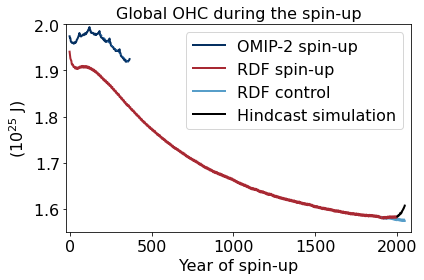

In [30]:
fig = plt.figure(figsize=(6,4),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(1, 1) 

# --------------------------------------------------------------------------- #
# --- Panel 2: Spin-up ------------------------------------------------------ #
# --------------------------------------------------------------------------- #
ax1 = plt.subplot(gs[0,0])
# 1° runs
p4 = plt.plot(t,OHC_1deg_HH, c = rotblau[20], label = 'OMIP-2 spin-up', linewidth=2)
# trend in the continued RDF_PI_Offset spin-up (i.e., the control run)
p1 = plt.plot(t[183:366], polyHH(t[183:366]), c = rotblau[18], linestyle = '--', linewidth=1)

# -------------- 
p1 = plt.plot(ds5.year-1962,ds5,c = rotblau[3], linewidth=2, label = 'RDF spin-up')       # the spin-up
p1 = plt.plot(ds6.year-1962,ds6,c = rotblau[15], linewidth=2)      # the spin-up continued
p1 = plt.plot(ds7.year-1972+2000,ds7,c = rotblau[15], linewidth=2, label = 'RDF control') # the control simulations
p1 = plt.plot(ds8.year-1962,ds8,c = rotblau[3], linewidth=2)       # the scaling spin-up
p1 = plt.plot(ds9.year-1972+2000,ds9,c = 'k', linewidth=2, label = 'Hindcast simulation')         # the interannual hindcast simulation
# -------------- 


# set fontsizes and labels
ax1.set_xlabel('Year of spin-up', fontsize=16)
ax1.set_ylabel('($10^{25}$ J)', fontsize=16)
plt.title('Global OHC during the spin-up', fontsize=16) # title
plt.xticks(fontsize=16) # ticklabel  size
plt.yticks(fontsize=16)
ax1.yaxis.offsetText.set_fontsize(16)
ax1.yaxis.major.formatter._useMathText = True # use scientific notation

ax1.legend(fontsize = 16, loc='upper right') # add legend

xt = ax1.get_xticks() # adding a custom tick for the 1972-2018 period

plt.locator_params(axis='y', nbins=6) # number of y ticks and ticklabels
plt.locator_params(axis='x', nbins=5) # number of y ticks and ticklabels

plt.xlim([-20, 2083]); plt.ylim([1.55, 2])    



# --- saving as 300 dpi .PNG image in specified folder ------------------------
plt.savefig(save + 'timeseries_OHC_spin-up_with_inset_poster', dpi=300, facecolor='w', 
            edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches=None, 
            pad_inches=0.1, metadata=None)
#print(datetime.now() - startTime) # end time of script
# %% end of script ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Wall time: 28.6 s

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #